In [1]:
# set cuda visible devices
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [5]:
import torch

from auto_circuit.types import AblationType
from auto_circuit.utils.graph_utils import patchable_model, set_mask_batch_size, train_mask_mode
from auto_circuit.model_utils.sparse_autoencoders.autoencoder_transformer import (
    sae_model, 
    AutoencoderTransformer
)

from cupbearer import tasks, scripts, utils
from cupbearer.tasks.tiny_natural_mechanisms import get_effect_tokens 
from cupbearer.detectors.extractors.eap_extractor import EAPFeatureExtractor, set_model

from elk_experiments.tiny_natural_mechanisms_utils import get_task_subset
from elk_experiments.auto_circuit_utils import make_prompt_data_loader

# Load SAE

In [6]:
# hmm probably want to to thresholding before trying anomaly detection
from transformer_lens import HookedTransformer

model_name = "pythia-70m-deduped"
device = "cuda"
task_name = "ifelse"

autoencoder_input = "resid_delta_mlp"
pythia_size = "0_8192"

task = get_task_subset(tasks.tiny_natural_mechanisms(task_name, device, model_name), 64, 32, 32)

base_model: HookedTransformer = task.model

base_model.set_use_attn_result(True)
base_model.set_use_attn_in(True)
base_model.set_use_split_qkv_input(True)
base_model.set_use_hook_mlp_in(True)

base_model.cfg.use_attn_result = True
base_model.cfg.use_attn_in = True
base_model.cfg.use_split_qkv_input = True
base_model.cfg.use_hook_mlp_in = True
base_model.eval()

ac_base_model = patchable_model(
    base_model, 
    factorized=True,
    slice_output="last_seq",
    separate_qkv=True
)

model = sae_model(
    base_model,
    autoencoder_input,
    load_pretrained=True,
    pythia_size=pythia_size,
    new_instance=True
)

ac_model = patchable_model(
    model,
    factorized=True,
    slice_output="last_seq",
    separate_qkv=True
)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loaded pretrained model pythia-70m-deduped into HookedTransformer


Downloading: "https://baulab.us/u/smarks/autoencoders/pythia-70m-deduped/mlp_out_layer0/0_8192/ae.pt" to /nas/ucb/oliveradk/elk-experiments/auto-circuit/.autoencoder_cache/pythia-70m-deduped_layer_0_0_8192.pt
100%|██████████| 32.0M/32.0M [00:07<00:00, 4.38MB/s]
Downloading: "https://baulab.us/u/smarks/autoencoders/pythia-70m-deduped/mlp_out_layer1/0_8192/ae.pt" to /nas/ucb/oliveradk/elk-experiments/auto-circuit/.autoencoder_cache/pythia-70m-deduped_layer_1_0_8192.pt
100%|██████████| 32.0M/32.0M [00:02<00:00, 13.7MB/s]
Downloading: "https://baulab.us/u/smarks/autoencoders/pythia-70m-deduped/mlp_out_layer2/0_8192/ae.pt" to /nas/ucb/oliveradk/elk-experiments/auto-circuit/.autoencoder_cache/pythia-70m-deduped_layer_2_0_8192.pt
100%|██████████| 32.0M/32.0M [00:02<00:00, 13.4MB/s]
Downloading: "https://baulab.us/u/smarks/autoencoders/pythia-70m-deduped/mlp_out_layer3/0_8192/ae.pt" to /nas/ucb/oliveradk/elk-experiments/auto-circuit/.autoencoder_cache/pythia-70m-deduped_layer_3_0_8192.pt
100%|

In [7]:
ac_base_model.n_edges, ac_model.n_edges, ac_model.n_edges / ac_base_model.n_edges

(3580, 3124351, 872.7237430167597)

In [11]:
out = ac_model(task.trusted_data[0][0])

In [8]:
# from copy import deepcopy
# effect_tokens= get_effect_tokens(task_name, task.model)
# train_loader = make_prompt_data_loader(task.trusted_data, effect_tokens, task.model, 32)
# pruned_model = deepcopy(model)
# pruned_model._prune_latents_with_dataset(
#     dataloader=train_loader,
#     max_latents=1000, 
#     include_corrupt=False, 
#     seq_len=None
# )

Running dataset for autoencoder pruning...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Done. Autoencoder activated latent counts: [5045, 5827, 3473, 4149, 5917, 4755]
Autoencoder latent counts: [1000, 1000, 1000, 1000, 1000, 1000]
Pruned vs. Unpruned KL Div: 0.15515241026878357


In [9]:
ac_pruned_model = patchable_model(
    pruned_model,
    factorized=True,
    slice_output="last_seq",
    separate_qkv=True
)

In [11]:
ac_base_model.n_edges, ac_pruned_model.n_edges, ac_pruned_model.n_edges / ac_base_model.n_edges

(3580, 384199, 107.318156424581)

## Edge Attribution Detection

In [19]:
task_name = "ifelse"
model_name = "pythia-70m-deduped"
device = "cpu"

task = get_task_subset(tasks.tiny_natural_mechanisms(task_name, device, model_name), 64, 32, 32)

task.model.cfg.use_attn_result = True
task.model.cfg.use_attn_in = True
task.model.cfg.use_split_qkv_input = True
task.model.cfg.use_hook_mlp_in = True
task.model.eval()


# default_model = HookedTransformer.from_pretrained("pythia-70m-deduped")
layer_idx = 3
autoencoder_input = "resid_delta_mlp"
pythia_size = "0_8192"


task.model = sae_model(
    task.model,
    autoencoder_input,
    load_pretrained=True,
    pythia_size=pythia_size,
    new_instance=False
)


Loaded pretrained model attn-only-1l into HookedTransformer
Moving model to device:  cpu


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loaded pretrained model pythia-70m-deduped into HookedTransformer
Moving model to device:  cpu


In [16]:
next(iter(train_loader)).clean.shape

torch.Size([32, 16])

In [20]:
# prune latents


Running dataset for autoencoder pruning...


Done. Autoencoder activated latent counts: [5046, 5827, 3473, 4149, 5917, 4755]
Autoencoder latent counts: [5046, 5046, 3473, 4149, 5046, 4755]
Pruned vs. Unpruned KL Div: 5.016931754653342e-05


In [21]:
eap_feature_extractor = EAPFeatureExtractor(
    effect_tokens=get_effect_tokens(task_name, task.model),
    model=task.model,
    grad_function="prob",
    answer_function="avg_val",
    ablation_type=AblationType.ZERO,
    abs_value=True,
    integrated_grad_samples=None,
    resid_src=True,
    resid_dest=True,
    attn=True,
    mlp=True
)

In [29]:
next(iter(eap_feature_extractor.model.patch_masks.values())).shape

torch.Size([10109])

In [22]:
eap_feature_extractor.model(next(iter(train_loader)).clean)

KeyboardInterrupt: 

In [4]:
eap_feature_extractor.compute_patch_out(task.trusted_data, batch_size=32)

: 

In [5]:
# train detector
from cupbearer.detectors.statistical import MahalanobisDetector
detector = MahalanobisDetector(
    feature_extractor=eap_feature_extractor
)

2024-07-18 21:23:54.720 | DEBUG    | cupbearer.detectors.statistical.statistical:_train:53 - Collecting statistics on trusted data
2024-07-18 21:23:55.914 | DEBUG    | cupbearer.detectors.statistical.statistical:init_variables:95 - Activation sizes: 
eap_scores: torch.Size([2880])
  0%|          | 0/64 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
100%|██████████| 64/64 [01:03<00:00,  1.01it/s]


2024-07-18 21:26:06.781 | INFO     | cupbearer.detectors.anomaly_detector:get_eval_results:343 - AUC_ROC (all): 0.6744
2024-07-18 21:26:06.782 | INFO     | cupbearer.detectors.anomaly_detector:get_eval_results:344 - AP (all): 0.6541


(defaultdict(dict,
             {'all': {'AUC_ROC': 0.6744060516357422,
               'AP': 0.6540885437001855}}),
 {'all': <Figure size 640x480 with 1 Axes>})

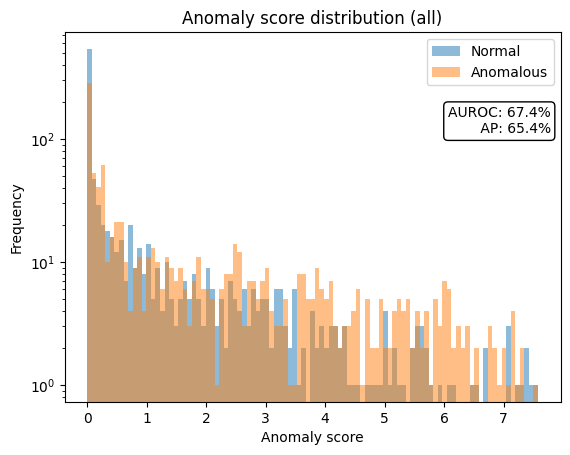

In [6]:
bs = 32
scripts.train_detector(
    task, detector, save_path=None,eval_batch_size=bs
)